# Plate scale II: make star pairs file from stars_all.fits file

This is a very simple process notebook to take the full set of possible
stars for plate scale calibration and extract pairs within an obsid that 
can be used in the plate scale fitting process.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('bmh')
import itertools
import chandra_aca.transform
from Ska.Matplotlib import plot_cxctime

from astropy.table import Table

In [2]:
stars_all = Table.read('stars_all.fits')

In [3]:
stars_all = stars_all[stars_all['t_aca'] != -99]

In [4]:
stars_all = stars_all.group_by('obsid')

## Quick validation: yag/zag from star RA/Dec + quat matches OBC centroids

In the code below, `star_yag,zag` are derived using the OBC quaternion at `mid_time` and the
star RA, Dec (PM-corrected) from the AGASC.

In [5]:
mean_dys = []
mean_dzs = []
ddys = []
ddzs = []
for stars in stars_all.groups:
    dy = stars['aoacyan_mean'] - stars['star_yag']
    dz = stars['aoaczan_mean'] - stars['star_zag']
    mean_dys.append(np.mean(dy))
    mean_dzs.append(np.mean(dz))
    ddys.append(dy - mean_dys[-1])
    ddzs.append(dz - mean_dzs[-1])

In [6]:
ddys = np.concatenate(ddys)
ddzs = np.concatenate(ddzs)

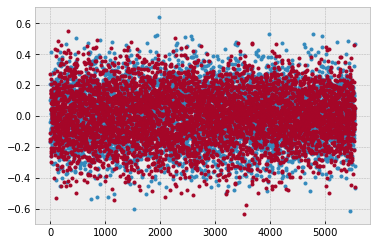

In [7]:
plt.plot(ddys, '.')
plt.plot(ddzs, '.');

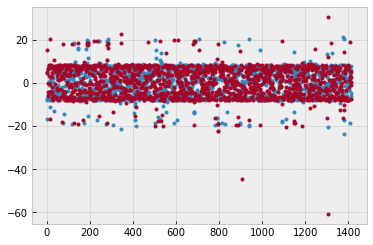

In [8]:
# This is offset of predicted yag/zag at a single time (mid_time) from
# the mean centroids over the whole observation.  The different reflects
# the dither amplitude.

plt.plot(mean_dys, '.')
plt.plot(mean_dzs, '.');

## Make some star pairs!

In [9]:
def dist(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [11]:
rows = []
for stars in stars_all.groups:
    for star1, star2 in itertools.combinations(stars, 2):
        yz_dist = dist(star1['star_yag'], star1['star_zag'], 
                       star2['star_yag'], star2['star_zag'])
        rc_dist = dist(star1['cent_i'], star1['cent_j'], 
                       star2['cent_i'], star2['cent_j'])
        row = [star1['obsid'], star1['t_aca'], star1['kalman_tstart'], star1['kalman_datestart']]
        row.extend([yz_dist, rc_dist,
                    star1['star_yag'], star1['star_zag'], 
                    star2['star_yag'], star2['star_zag'],
                    star1['cent_i'], star1['cent_j'], 
                    star2['cent_i'], star2['cent_j']])
        rows.append(row)

names=['obsid', 't_aca', 'tstart', 'datestart',
       'yz_dist', 'rc_dist',
       'yag1', 'zag1', 'yag2', 'zag2',
       'row1', 'col1', 'row2', 'col2']
pairs = Table(rows=rows, names=names)

In [12]:
pairs[:4]

<Table length=4>
obsid     t_aca         tstart    ...      row2          col2     
int64    float64       float64    ...    float64       float64    
----- ------------- ------------- ... ------------- --------------
 2519 14.2348555073 162519980.317 ... 434.308332221 -353.132588534
 2519 14.2348555073 162519980.317 ... -474.75678961  124.474358154
 2519 14.2348555073 162519980.317 ... -474.75678961  124.474358154
 2528 14.4979238094 142482635.784 ... 219.000468423  352.833118235

In [13]:
pairs.write('star_pairs.fits', overwrite=True)

In [14]:
len(pairs)

8945